In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm

from opacus import PrivacyEngine
from opacus.accountants.utils import get_noise_multiplier
from pyvacy import optim, analysis, sampling

from matplotlib import pyplot as plt

from aijack.defense import GeneralMomentAccountant

AIJack supports essential components of Differential Privacy, such as moment account. You can confirm that the behavior of AIJack is almost the same with opacus, a popular differential privacy library for PyTorch. Also, you can find that AIJack is much faster than opacus.

## `get_epsilon`

In [2]:
# get epsilon

result_a = []
result_b = []
result_c = []

for i in range(1, 51):

    iterations = 100
    noise_multiplier = 5.
    delta = 1e-5
    sampling_rate = i/1000

    ga = GeneralMomentAccountant(noise_type="Gaussian",
                                     search="ternary",
                                     precision=0.001,
                                     order_max=0,
                                     order_min=72,
                                     bound_type="rdp_upperbound_closedformula")

    ga.reset_step_info()
    ga.add_step_info({"sigma":noise_multiplier}, sampling_rate, iterations)
    temp = ga.get_epsilon(delta)
    result_a.append(temp)

    ga = GeneralMomentAccountant(noise_type="Gaussian",
                                     search="greedy",
                                     precision=0.001,
                                     orders=list(range(2, 64)),
                                     bound_type="rdp_tight_upperbound")

    ga.reset_step_info()
    ga.add_step_info({"sigma":noise_multiplier}, sampling_rate, iterations)
    temp = ga.get_epsilon(delta)
    result_b.append(temp)
    
    privacy_engine = PrivacyEngine()
    privacy_engine.accountant.steps.append((noise_multiplier, sampling_rate, iterations))
    result_c.append(privacy_engine.accountant.get_epsilon(delta))

C:\Users\kanka\AppData\Local\Programs\Python\Python39\lib\site-packages\opacus\privacy_engine.py:100: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\kanka\AppData\Local\Programs\Python\Python39\lib\site-packages\opacus\accountants\analysis\rdp.py:320: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


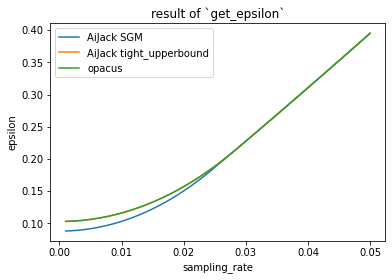

In [3]:
plt.plot([i/1000 for i in range(1, 51)], result_a, label="AiJack SGM")
plt.plot([i/1000 for i in range(1, 51)], result_b, label="AiJack tight_upperbound")
plt.plot([i/1000 for i in range(1, 51)], result_c, label="opacus")
plt.title("result of `get_epsilon`")
plt.xlabel("sampling_rate")
plt.ylabel("epsilon")
plt.legend()

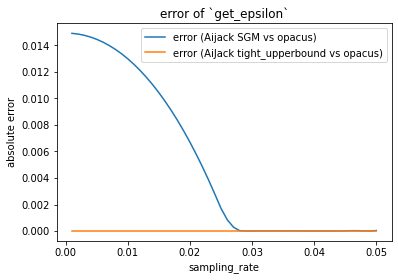

In [4]:
plt.plot([i/1000 for i in range(1, 51)], np.abs(np.array(result_a) - np.array(result_c)), label="error (Aijack SGM vs opacus)")
plt.plot([i/1000 for i in range(1, 51)], np.abs(np.array(result_b) - np.array(result_c)), label="error (AiJack tight_upperbound vs opacus)")
plt.title("error of `get_epsilon`")
plt.xlabel("sampling_rate")
plt.ylabel("absolute error")
plt.legend()

In [5]:
privacy_engine = PrivacyEngine()
privacy_engine.accountant.steps.append((noise_multiplier, sampling_rate, iterations))

ga = GeneralMomentAccountant(noise_type="Gaussian",
                             search="greedy",
                             precision=0.001,
                             orders=list(range(2, 64)),
                             bound_type="rdp_tight_upperbound")
ga.reset_step_info()
ga.add_step_info({"sigma":noise_multiplier}, sampling_rate, iterations)

ga_1 = GeneralMomentAccountant(noise_type="Gaussian",
                             search="ternary",
                             precision=0.001,
                             order_max=0,
                             order_min=72,
                             bound_type="rdp_upperbound_closedformula")

ga_1.reset_step_info()
ga_1.add_step_info({"sigma":noise_multiplier}, sampling_rate, iterations)

C:\Users\kanka\AppData\Local\Programs\Python\Python39\lib\site-packages\opacus\privacy_engine.py:100: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


In [6]:
%%timeit
privacy_engine.accountant.get_epsilon(delta)

19.3 ms ± 3.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit
ga.get_epsilon(delta)

1.33 ms ± 310 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%%timeit
ga_1.get_epsilon(delta)

816 µs ± 180 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## `get_noise_multipler`

In [13]:
ga = GeneralMomentAccountant(noise_type="Gaussian",
                                     search="greedy",
                                     precision=0.001,
                                     orders=list(range(2, 64)),
                                     bound_type="rdp_tight_upperbound")

ga_1 = GeneralMomentAccountant(noise_type="Gaussian",
                             search="ternary",
                                     precision=0.001,
                                     order_max=0,
                                     order_min=72,
                                     bound_type="rdp_upperbound_closedformula")


privacy_engine = PrivacyEngine()

print(ga.get_noise_multiplier("sigma", 1, 1e-5, 0.01, 100))
print(ga_1.get_noise_multiplier("sigma", 1, 1e-5, 0.01, 100))
print(get_noise_multiplier(
                target_epsilon=1,
                target_delta=1e-5,
                sample_rate=0.01,
                epochs=100,
                accountant=privacy_engine.accountant.mechanism()
            ))

4.130859375
4.130859375
4.119272460937499


In [14]:
%%timeit
get_noise_multiplier(
                target_epsilon=1,
                target_delta=1e-5,
                sample_rate=0.01,
                epochs=100,
                accountant=privacy_engine.accountant.mechanism()
            )

208 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit
ga.get_noise_multiplier("sigma", 1, 1e-5, 0.01, 100)

15.7 ms ± 7.24 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%%timeit
ga_1.get_noise_multiplier("sigma", 1, 1e-5, 0.01, 100)

8.25 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
